Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [38]:
from glob import glob

In [41]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*', '*.jpg'))]

In [42]:
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [44]:
original_df.Label.value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size, seed = 123 )

Found 2239 files belonging to 9 classes.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size, seed = 123 )

Found 118 files belonging to 9 classes.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2025-02-16 18:26:38.925510: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


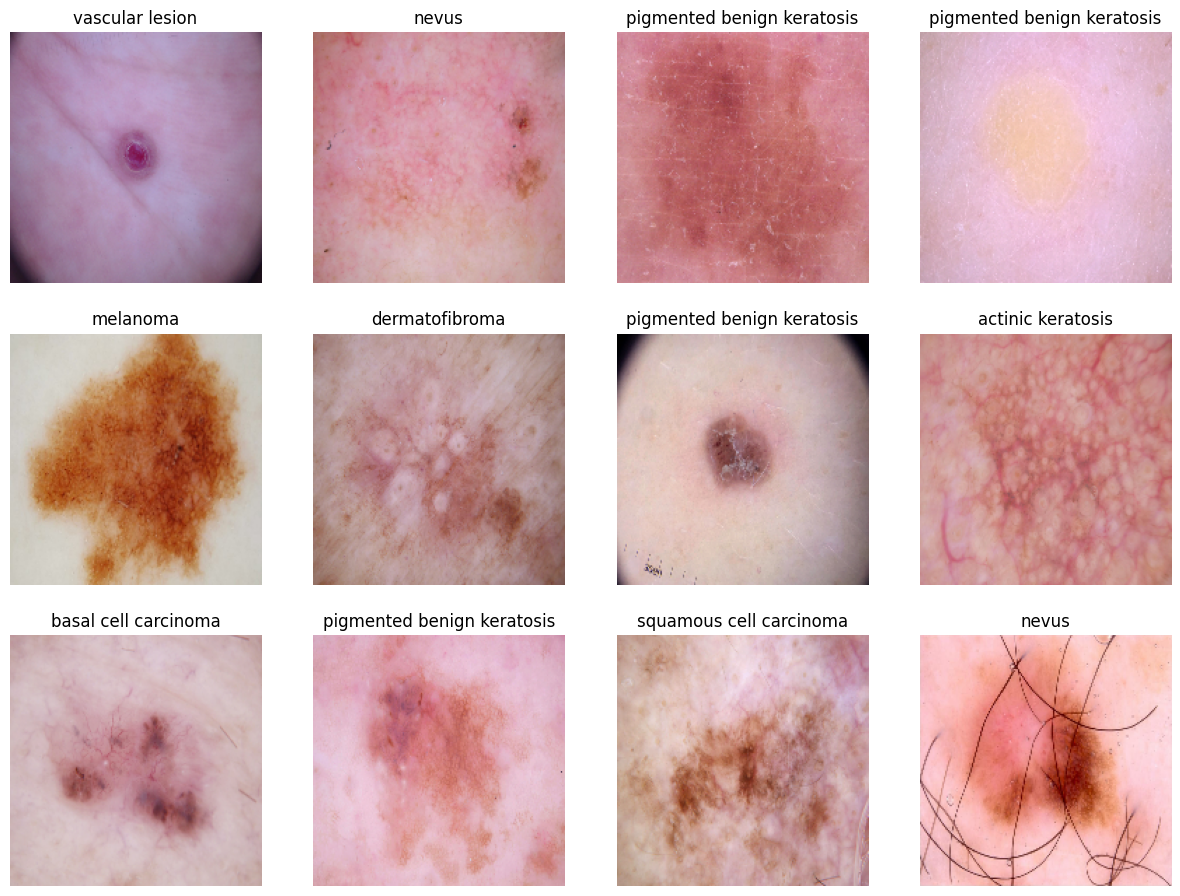

In [8]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
num_classes = len(class_names)

model = Sequential([
    # rescaling layer
  layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    # 1st conv layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # 2nd conv layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # 3rd conv layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
     # maxpooling layer
  layers.MaxPooling2D(),
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
    # output dense layer
  layers.Dense(num_classes,activation='softmax')
])

/opt/anaconda3/envs/tensor_flow/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/opt/anaconda3/envs/tensor_flow/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.2247 - loss: 2.1308 - val_accuracy: 0.2119 - val_loss: 2.1701
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.3663 - loss: 1.7463 - val_accuracy: 0.3051 - val_loss: 2.3480
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.4952 - loss: 1.4681 - val_accuracy: 0.3305 - val_loss: 2.3213
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.5335 - loss: 1.3431 - val_accuracy: 0.3305 - val_loss: 2.1226
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.5514 - loss: 1.2513 - val_accuracy: 0.4153 - val_loss: 2.5302
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.5609 - loss: 1.2024 - val_accuracy: 0.3475 - val_loss: 2.3894
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.5941 - loss: 1.0986 - val_accuracy: 0.3051 - val_loss: 2.7128
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.6289 - loss: 1.0151 - val_accuracy: 0.3729 - val_loss: 2

### Visualizing training results

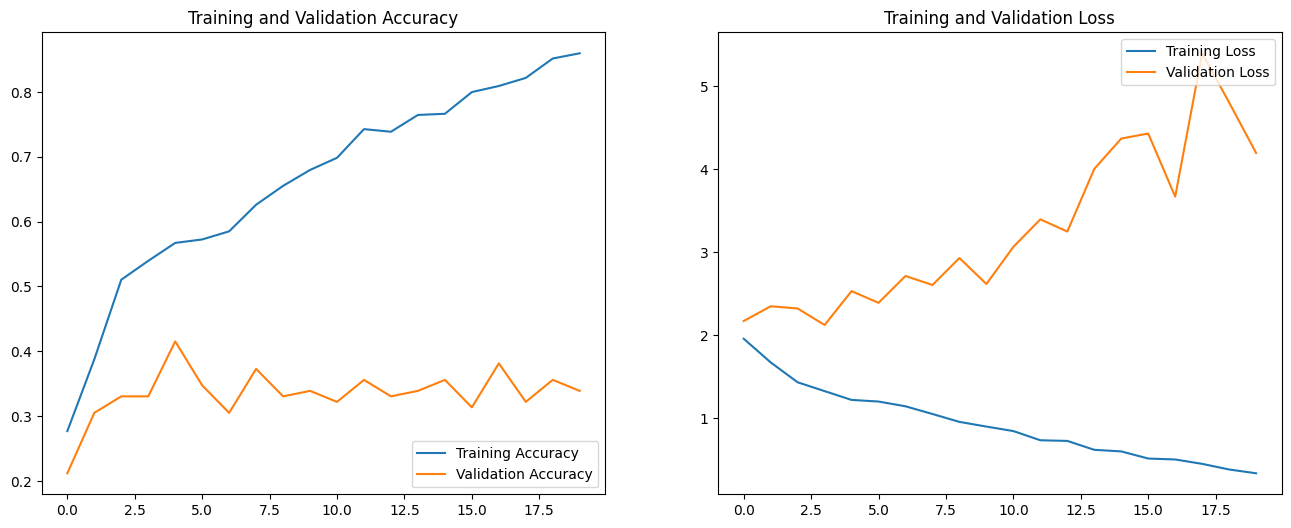

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

# Results -
1. Model is overfitting, training accuracy is continously increasing but test accuracy is dropping
2. Have to understand the data further and add augmentations

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1)
])

2025-02-16 18:30:46.244294: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


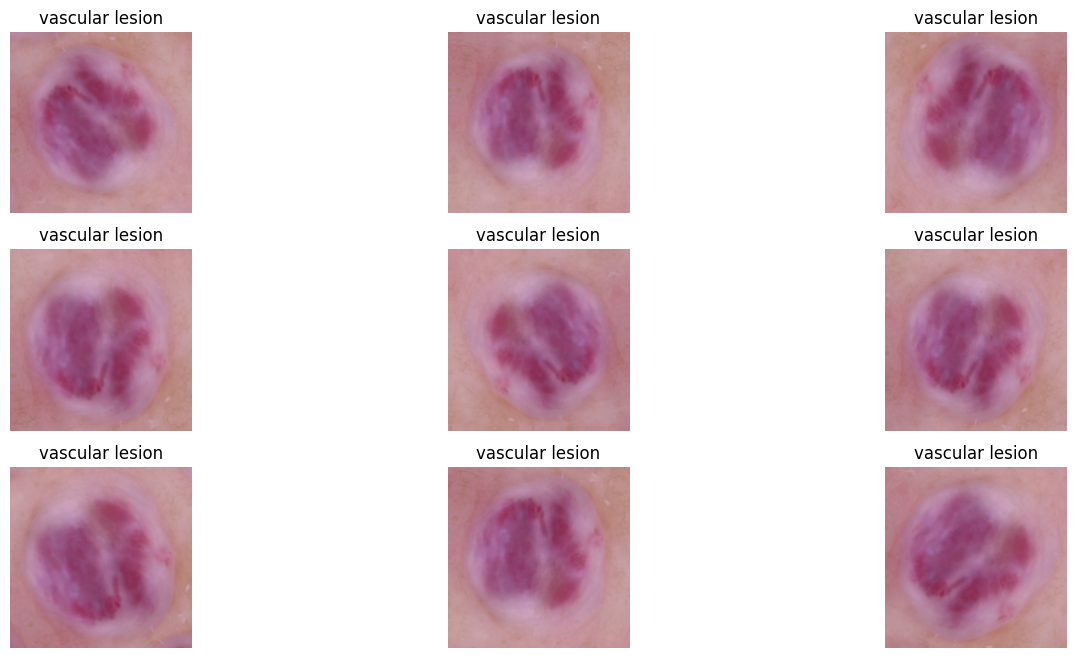

In [22]:
plt.figure(figsize=(16, 8))
for images, labels in train_ds.take(1):
    for i in range(num_classes):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")
plt.show()

# plt.figure(figsize=(15, 15))
# for images, labels in train_ds.take(1):
#   for i in range(12):
#     ax = plt.subplot(4, 4, i + 1)
#     augmented_images = data_augmentation(images[i])
#     plt.imshow(augmented_images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [23]:
model_new = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9,activation='softmax', name="outputs")
])

### Compiling the model

In [24]:
model_new.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model_new.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [26]:
epochs = 20
history = model_new.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.2140 - loss: 2.1085 - val_accuracy: 0.1949 - val_loss: 2.4766
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.3559 - loss: 1.7938 - val_accuracy: 0.3136 - val_loss: 2.1879
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.4073 - loss: 1.6539 - val_accuracy: 0.1864 - val_loss: 2.3661
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.4390 - loss: 1.6145 - val_accuracy: 0.2881 - val_loss: 2.3363
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.4876 - loss: 1.5202 - val_accuracy: 0.3644 - val_loss: 2.4077
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.5026 - loss: 1.4483 - val_accuracy: 0.3305 - val_loss: 2.3898
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.5279 - loss: 1.3926 - val_accuracy: 0.2881 - val_loss: 2.2096
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.5184 - loss: 1.3824 - val_accuracy: 0.

### Visualizing the results

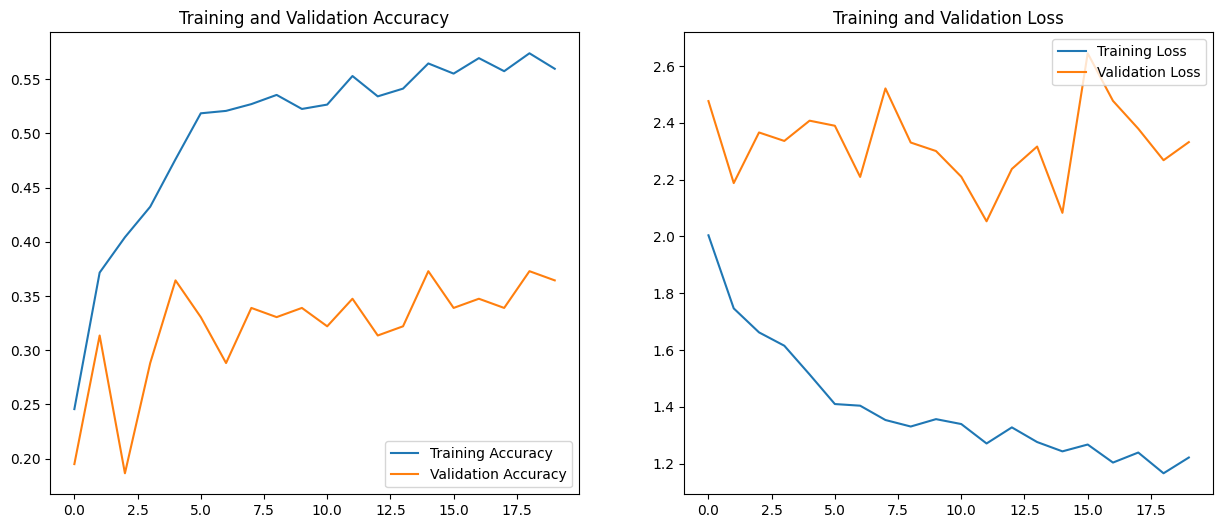

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
1. Overfitting is reduced but model is not getting converged
2. Test accuracy is still at similar level
3. Train accuracy has reduced, meaning reduction in overfitting but not sufficient data to get better validation results, only partially better performance

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
labels = list(train_ds.map(lambda x, y: y).as_numpy_iterator())
labels = np.concatenate(labels)  # Flatten the list of arrays

train_label_df = pd.DataFrame(np.unique(np.array(labels), return_counts = True)).T.rename(columns = {0:'name',1:'counts'})

train_label_df['names'] = train_label_df.name.apply(lambda x: class_names[x])

In [29]:
train_label_df['perc'] = (train_label_df.counts/train_label_df.counts.sum()).mul(100).round(2)

In [30]:
train_label_df[['names','counts', 'perc']]

,names,counts,perc
0,actinic keratosis,114,5.09
1,basal cell carcinoma,376,16.79
2,dermatofibroma,95,4.24
3,melanoma,438,19.56
4,nevus,357,15.94
5,pigmented benign keratosis,462,20.63
6,seborrheic keratosis,77,3.44
7,squamous cell carcinoma,181,8.08
8,vascular lesion,139,6.21


In [32]:
import seaborn as sns

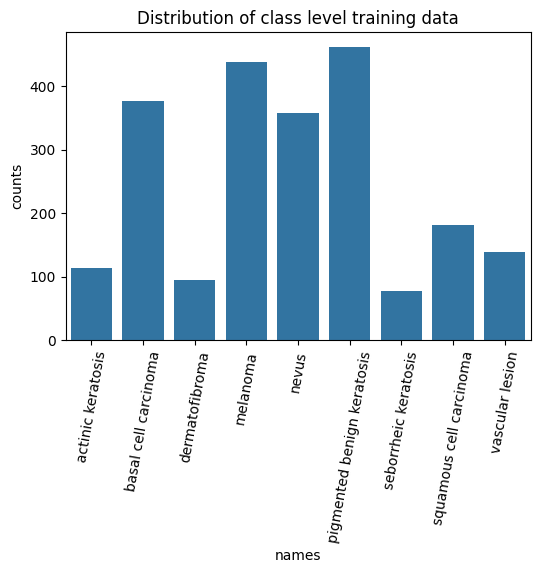

In [65]:
plt.figure(figsize=(6, 4))
sns.barplot(x = train_label_df['names'], y = train_label_df['counts'], data = train_label_df)
plt.xticks(rotation=80)
plt.title('Distribution of class level training data')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
    - seborrheic keratosis class has least number of samples, which is 77
#### - Which classes dominate the data in terms proportionate number of samples?
    - classes dominating are - pigmented benign keratosis	, melanoma	, basal cell carcinoma and nevus


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [93]:
!pip install Augmentor


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B0BE6A0>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 413.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B110BE0>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 456.33 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B0B9730>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 432.92 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x30F1769A0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 113.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x30B110FA0>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.64 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B0521F0>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 429.98 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x30F17CE50>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 225.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B0BE640>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 427.73 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x39831F2B0>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 422.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [45]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [50]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])

In [52]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [53]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [88]:
os.getcwd()

'/Users/cars24/Documents/LearningIIITB/CNN/Assignment/Skin cancer ISIC The International Skin Imaging Collaboration'

In [ ]:
# os.chdir('Skin cancer ISIC The International Skin Imaging Collaboration')

# import shutil

In [89]:
#os.chdir('/Users/cars24/Documents/LearningIIITB/CNN/Assignment/')

In [53]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels = 'inferred',
    seed=123,
    validation_split = 0.2,
    subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


2025-02-16 18:43:22.819906: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


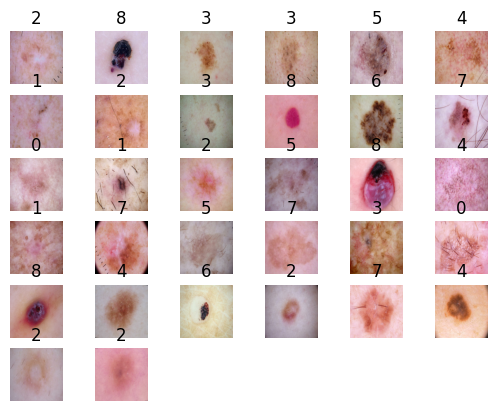

In [55]:
for img, tag in train_ds.take(1):
    for i in range(len(img)):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(tag.numpy()[i])
        plt.axis("off")

#### **Todo:** Create a validation dataset

In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [57]:
# checking the class names
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [58]:
# Autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [59]:
# creating the sequential model with rescaling, 3 conv, 3 maxpooling, 3 dropouts and 2 dense layers
model = Sequential([
  layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

/opt/anaconda3/envs/tensor_flow/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

#### **Todo:**  Train your model

In [63]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/opt/anaconda3/envs/tensor_flow/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.1701 - loss: 2.5088 - val_accuracy: 0.3244 - val_loss: 1.9615
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.3603 - loss: 1.7236 - val_accuracy: 0.4091 - val_loss: 1.6420
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.4571 - loss: 1.4460 - val_accuracy: 0.4670 - val_loss: 1.5135
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5143 - loss: 1.2852 - val_accuracy: 0.5271 - val_loss: 1.3680
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5664 - loss: 1.1938 - val_accuracy: 0.5917 - val_loss: 1.1532
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.6113 - loss: 1.0743 - val_accuracy: 0.5887 - val_loss: 1.1631
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.6602 - loss: 0.9454 - val_accuracy: 0.6310 - val_loss: 1.0416
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.7011 - loss: 0.8481 - val

#### **Todo:**  Visualize the model results

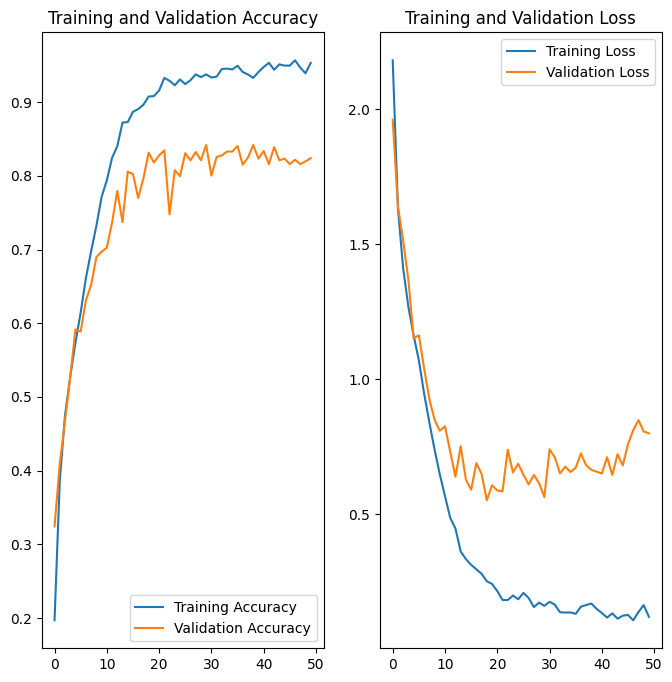

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Impacts of adding images to introduce class balance in training data -
1. Both train and test accuracy has improved, with test data accuracy at >80%

## testing at unseen data

In [ ]:
predictions = []
true_labels = []
images = []

for batch_images, batch_labels in val_ds:
    preds = model.predict(batch_images)  # Get model predictions
    predictions.extend(np.argmax(preds, axis=1))  # Convert softmax output to class index
    true_labels.extend(batch_labels.numpy())  # Store true labels
    images.extend(batch_images.numpy())  # Store images for visualization

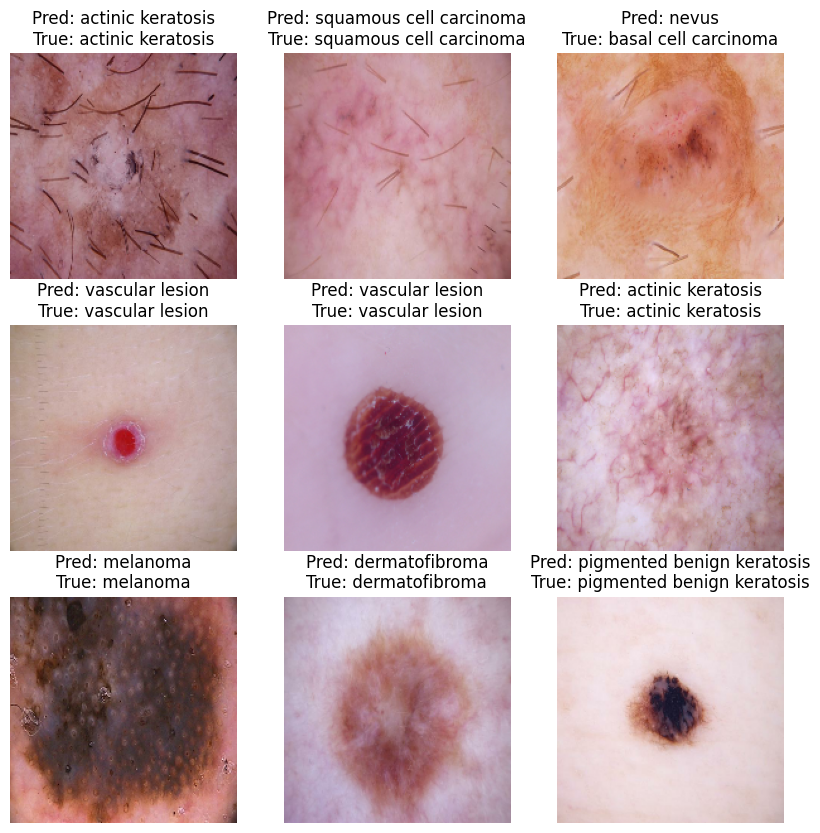

In [70]:
predicted_labels = [class_names[i] for i in predictions]
true_class_labels = [class_names[i] for i in true_labels]

# Visualize some predictions
num_samples = 9  # Display first 9 images
plt.figure(figsize=(10, 10))

for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {true_class_labels[i]}")
    plt.axis("off")

plt.show()